
# Neural XC training: QNN models 

### Note: To showcase the training process we only use 2 epochs

We retrace the steps of the original KSR model in the paper:
https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.036401

The following steps are performed:

1. Load configuration
2. Load dataset
3. Define model
4. Train model


In [1]:
import os
import sys
from pathlib import Path

import glob
import json
import pickle
import time

import jax
from jax import random
from jax import tree_util
from jax import config
import jax.numpy as jnp
from jax_dft import datasets
from jax_dft import jit_scf
from jax_dft import losses
from jax_dft import neural_xc
from jax_dft import np_utils
from jax_dft import scf
from jax_dft import utils
from jax_dft import xc
import matplotlib.pyplot as plt
import numpy as np
import scipy

import qedft
from qedft.config.config import Config
from qedft.data_io.dataset_loader import load_molecular_datasets_from_config
from qedft.train.od.train import create_kohn_sham_fn, create_loss_fn, create_training_step

# Set the default dtype as float64
config.update('jax_enable_x64', True)

project_path = os.path.dirname(os.path.dirname(qedft.__file__))
print(f"Project path: {project_path}")

# Initialize a configuration object to manage our settings
# Define the project path, assuming 'settings.yaml' is located in the root directory
project_path = Path(os.path.dirname(os.path.dirname(qedft.__file__)))
# Load configuration settings from a YAML file
config = Config(config_path=project_path / 'qedft' / 'config' / 'train_config.yaml')
config_dict = config.config
config_dict

Project path: /Users/igorsokolov/PycharmProjects/qedft


{'name': 'test',
 'experiment_name': 'test',
 'network_type': 'ksr',
 'molecule_name': 'h2',
 'molecule_names': ['h2'],
 'dataset1': [128, 384],
 'rng': 0,
 'save_plot_loss': False,
 'save_every_n': 20,
 'activation': 'tanh',
 'n_neurons': 513,
 'n_layers': 2,
 'n_qubits': 9,
 'n_reupload_layers': 1,
 'use_rzz_parametrized_entanglers': False,
 'chebychev_reuploading': False,
 'add_reversed_rzz': False,
 'entangling_block_type': 'alternate_linear',
 'single_qubit_rotations': ['rz', 'rx', 'rz'],
 'use_same_parameters': False,
 'add_negative_transform': False,
 'wrap_with_self_interaction_layer': False,
 'wrap_with_global_functional': False,
 'use_correlators_in_output': False,
 'output_operators': ['Z'],
 'use_bias_in_output': False,
 'max_train_steps': 10000,
 'factr': 1.0,
 'pgtol': 1e-14,
 'm': 20,
 'maxfun': 20,
 'maxiter': 2,
 'num_iterations': 15,
 'ks_iter_to_ignore': 10,
 'discount_factor': 0.9,
 'alpha': 0.5,
 'alpha_decay': 0.9,
 'num_mixing_iterations': 1,
 'density_mse_conver

In [2]:

base_path = project_path / "data" / "od"
base_path = Path(base_path)
list_datasets = load_molecular_datasets_from_config(
    config_dict,
    base_path,
    check_grid_centering=True
)
print(list_datasets)

dataset = list_datasets[0][0]  # first dataset
train_set = list_datasets[0][1] # train set

# Same grids for all datasets
grids = dataset.grids
print(f"Grids: {len(grids)}")
initial_density = scf.get_initial_density(train_set, method='noninteracting')
initial_density  # initial density for training set
# save initial density
# with open('initial_density.pkl', 'wb') as f:
#     pickle.dump(initial_density, f)


2025-04-14 16:19:37.807 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:63 - Loading dataset for h2
2025-04-14 16:19:37.807 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:83 - Loading dataset from /Users/igorsokolov/PycharmProjects/qedft/data/od/h2
2025-04-14 16:19:37.811 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:95 - Training distances: [128, 384]
2025-04-14 16:19:37.812 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:101 - Number of electrons: 2
2025-04-14 16:19:37.813 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:102 - Grid shape: (513,)


[(<jax_dft.datasets.Dataset object at 0x107aa6aa0>, KohnShamState(density=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), total_energy=array([-2.06208973, -1.57112312]), locations=array([[-0.64,  0.64],
       [-1.92,  1.92]]), nuclear_charges=array([[1, 1],
       [1, 1]], dtype=int32), external_potential=array([[-0.00041461, -0.00042875, -0.00044337, ..., -0.00044337,
        -0.00042875, -0.00041461],
       [-0.00053689, -0.0005552 , -0.00057414, ..., -0.00057414,
        -0.0005552 , -0.00053689]]), grids=array([[-20.48, -20.4 , -20.32, ...,  20.32,  20.4 ,  20.48],
       [-20.48, -20.4 , -20.32, ...,  20.32,  20.4 ,  20.48]]), num_electrons=array([2, 2]), hartree_potential=None, xc_potential=None, xc_energy_density=None, gap=None, converged=array([ True,  True])))]
Grids: 513


Array([[1.36020925e-28, 5.94003127e-28, 1.41151404e-27, ...,
        1.41137527e-27, 5.93883692e-28, 1.35992932e-28],
       [1.93532611e-23, 8.40949500e-23, 1.98255592e-22, ...,
        1.98256097e-22, 8.40953773e-23, 1.93532894e-23]], dtype=float64)

***
## Training  Local PrQNN

In [3]:
use_amplitude_encoding = False
if not use_amplitude_encoding:
    config_dict.update({'network_type': 'ksr'})
else:
    config_dict.update({'network_type': 'mlp_ksr'})
config_dict.update({'use_amplitude_encoding': use_amplitude_encoding})

In [4]:

from qedft.models.networks import LocalQNN
from qedft.models.wrappers import wrap_network_from_config

model = LocalQNN(config_dict={"qnn_type": "LocalQNN", "layer_type": "DirectQNN"})

num_points = 513
prng = jax.random.PRNGKey(0)
inputs = jax.random.uniform(
    prng,
    minval=-4 * jnp.pi,
    maxval=4 * jnp.pi,
    shape=(num_points,),
)

# Build network
network = model.build_network(inputs)

# Initialize parameters and run inference
init_fn, apply_fn = network
_, params = init_fn(prng, input_shape=(-1, num_points, 1))
output = apply_fn(params, inputs)


wrapped_network = wrap_network_from_config(network, grids, config_dict)

# Test direct initialization networks
init_fn, neural_xc_energy_density_fn = wrapped_network
init_params = init_fn(prng, input_shape=(1,))

# JIT the neural_xc_energy_density_fn
neural_xc_energy_density_fn = jax.jit(neural_xc_energy_density_fn)

output = neural_xc_energy_density_fn(inputs, init_params)
print("output.shape", output.shape)

spec, flatten_init_params = np_utils.flatten(init_params)

params = init_fn(prng)
neural_xc_energy_density_fn(inputs, params)

2025-04-14 16:19:39.161 | INFO     | qedft.models.quantum.quantum_models:build_qnn:682 - Building LocalQNN QNN with DirectQNN layer_type


output.shape (513,)


Array([ 1.95507850e+00,  1.77475075e+00,  1.43255386e+00,  1.09081267e+00,
        1.61506550e+00,  6.68170652e-01,  9.97259620e-01, -3.42947063e-02,
        1.25625624e+00,  9.26421190e-02,  1.92570176e+00, -1.26312593e-01,
        1.85346643e+00,  9.76064720e-01, -2.39865562e-01, -1.28946851e-01,
       -1.96338150e-01, -5.00854769e-02, -1.38762067e-01,  2.62212745e-01,
       -6.41142571e-04, -2.13709761e-01, -1.47752738e-01, -6.26411712e-02,
       -1.51056717e-01,  2.85903868e-02,  1.30759373e+00, -3.43784111e-03,
        3.30213224e-01,  1.42075928e+00,  1.95934942e+00,  3.87334689e-01,
        5.97783617e-02,  1.88134322e-01,  1.77710925e+00, -7.19940023e-02,
        1.37336257e+00,  5.53481676e-01, -4.54245950e-02, -5.25637552e-02,
       -2.15901114e-01,  9.47309697e-01,  3.03024696e-01, -1.22681745e-01,
       -1.74557573e-02, -1.55108177e-01,  1.59025509e+00, -1.72679690e-01,
       -2.92101400e-03, -2.31945593e-01, -9.26273945e-02, -1.80885848e-01,
       -1.55789518e-01, -

In [5]:
# Create Kohn-Sham function and its batched version
kohn_sham_fn, batch_kohn_sham = create_kohn_sham_fn(
    config_dict, dataset, grids, neural_xc_energy_density_fn, spec)
# Create and initialize loss function
loss_fn = create_loss_fn(batch_kohn_sham, grids, dataset, config_dict)
# Create value and gradient function
value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))
# Create training step function
training_step = create_training_step(
    value_and_grad_fn, train_set, initial_density,
    save_every_n=1, initial_checkpoint_index=0, checkpoint_dir=project_path / 'tests' / 'product_qnn' / 'ckpts', spec=spec
)

In [6]:
# Optimize using L-BFGS-B
x, f, info = scipy.optimize.fmin_l_bfgs_b(
    training_step,
    x0=np.array(flatten_init_params),
    maxfun=2,
    factr=config_dict['factr'],
    m=config_dict['m'],
    pgtol=config_dict['pgtol'],
    maxiter=2
)

2025-04-14 16:19:41.229 | INFO     | qedft.train.od.train:_kohn_sham:115 - Jitting kohn_sham_func
2025-04-14 16:19:51.720 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 0, loss 28.52966580954717 in 7.79564905166626 sec
2025-04-14 16:19:51.721 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/igorsokolov/PycharmProjects/qedft/tests/product_qnn/ckpts/ckpt-00000
2025-04-14 16:19:53.950 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 1, loss 0.34755277076952434 in 0.00018978118896484375 sec
2025-04-14 16:19:53.951 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/igorsokolov/PycharmProjects/qedft/tests/product_qnn/ckpts/ckpt-00001
2025-04-14 16:19:56.470 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 2, loss 0.6291141617851747 in 0.00023818016052246094 sec
2025-04-14 16:19:56.472 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/igors

In [7]:
from qedft.train.od.eval import eval_trained_model

# Plotting the states of the Kohn-Sham calculation for a given distance.
plot_distances = [40, 88, 128, 184, 232,384, 400, 504, 600] #@param
plot_set = dataset.get_molecules(plot_distances)
plot_initial_density = scf.get_initial_density(
    plot_set, method='noninteracting')
nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    plot_set.locations,
    plot_set.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)

path_to_ckpt = str(project_path) + '/tests/product_qnn/ckpts/ckpt-00002'

# Evaluating the trained model for a given distance.
states = eval_trained_model(
    ckpt_path=path_to_ckpt,
    plot_distances=plot_distances,
    plot_set=plot_set,
    plot_initial_density=plot_initial_density,
    num_electrons=dataset.num_electrons,
    num_iterations=config_dict['num_iterations'],
    grids=grids,
    neural_xc_energy_density_fn=neural_xc_energy_density_fn,
    use_amplitude_encoding=False,
    use_lda=False,
    alpha=config_dict['alpha'],
    alpha_decay=config_dict['alpha_decay'],
    num_mixing_iterations=config_dict['num_mixing_iterations'],
    density_mse_converge_tolerance=config_dict['density_mse_converge_tolerance'],
    enforce_reflection_symmetry=config_dict['enforce_reflection_symmetry'],
)

2025-04-14 16:20:02.143 | INFO     | qedft.train.od.eval:load_model_params:101 - Loading checkpoint from /Users/igorsokolov/PycharmProjects/qedft/tests/product_qnn/ckpts/ckpt-00002
2025-04-14 16:20:02.144 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 40
2025-04-14 16:20:06.566 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 88
2025-04-14 16:20:07.679 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 128
2025-04-14 16:20:08.714 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 184
2025-04-14 16:20:10.065 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 232
2025-04-14 16:20:11.220 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 384
2025-04-14 16:20:12.449 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 400
2025-04-14 16:20:13.457 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 504
2025-04-14 16:20:14.514 | INFO     | 

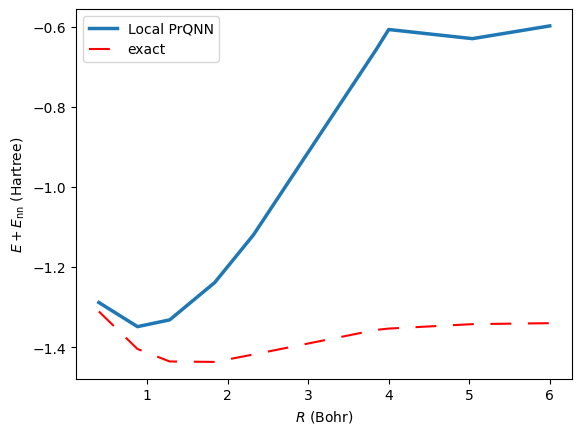

In [8]:
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + states.total_energy[:, -1], lw=2.5, label='Local PrQNN')
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + plot_set.total_energy,
    c='r', dashes=(10, 8), label='exact')
plt.xlabel(r'$R\,\,\mathrm{(Bohr)}$')
plt.ylabel(r'$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$')
plt.legend(loc=0)
plt.show()

***
## Training  Local ChQNN

In [9]:

from qedft.models.networks import LocalQNN
from qedft.models.wrappers import wrap_network_from_config

model = LocalQNN(config_dict={"qnn_type": "LocalQNN", "layer_type": "ChebyshevQNN"})

num_points = 513
prng = jax.random.PRNGKey(0)
inputs = jax.random.uniform(
    prng,
    minval=-4 * jnp.pi,
    maxval=4 * jnp.pi,
    shape=(num_points,),
)

# Build network
network = model.build_network(inputs)

# Initialize parameters and run inference
init_fn, apply_fn = network
_, params = init_fn(prng, input_shape=(-1, num_points, 1))
output = apply_fn(params, inputs)


use_amplitude_encoding = False
if not use_amplitude_encoding:
    config_dict.update({'network_type': 'ksr'})
else:
    config_dict.update({'network_type': 'mlp_ksr'})

wrapped_network = wrap_network_from_config(network, grids, config_dict)

# Test direct initialization networks
init_fn, neural_xc_energy_density_fn = wrapped_network
init_params = init_fn(prng, input_shape=(1,))

# JIT the neural_xc_energy_density_fn
neural_xc_energy_density_fn = jax.jit(neural_xc_energy_density_fn)

output = neural_xc_energy_density_fn(inputs, init_params)
print("output.shape", output.shape)

spec, flatten_init_params = np_utils.flatten(init_params)

params = init_fn(prng)
neural_xc_energy_density_fn(inputs, params)

2025-04-14 16:20:16.662 | INFO     | qedft.models.quantum.quantum_models:build_qnn:682 - Building LocalQNN QNN with ChebyshevQNN layer_type


output.shape (513,)


Array([0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995, 0.3692995,
       0.3692995, 0.3692995, 0.3692995, 0.3692995, 

In [10]:
config_dict.update({'use_amplitude_encoding': use_amplitude_encoding})
# Create Kohn-Sham function and its batched version
kohn_sham_fn, batch_kohn_sham = create_kohn_sham_fn(
    config_dict, dataset, grids, neural_xc_energy_density_fn, spec)
# Create and initialize loss function
loss_fn = create_loss_fn(batch_kohn_sham, grids, dataset, config_dict)
# Create value and gradient function
value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))
# Create training step function
training_step = create_training_step(
    value_and_grad_fn, train_set, initial_density,
    save_every_n=1, initial_checkpoint_index=0, checkpoint_dir=project_path / 'tests' / 'chebyshev_qnn' / 'ckpts', spec=spec
)
# Optimize using L-BFGS-B
x, f, info = scipy.optimize.fmin_l_bfgs_b(
    training_step,
    x0=np.array(flatten_init_params),
    maxfun=2,
    factr=config_dict['factr'],
    m=config_dict['m'],
    pgtol=config_dict['pgtol'],
    maxiter=2
)


2025-04-14 16:20:17.268 | INFO     | qedft.train.od.train:_kohn_sham:115 - Jitting kohn_sham_func
2025-04-14 16:20:29.303 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 0, loss 3.887465808932135 in 8.610862970352173 sec
2025-04-14 16:20:29.309 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/igorsokolov/PycharmProjects/qedft/tests/chebyshev_qnn/ckpts/ckpt-00000
2025-04-14 16:20:32.984 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 1, loss 13.038887185599211 in 0.00047707557678222656 sec
2025-04-14 16:20:32.986 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/igorsokolov/PycharmProjects/qedft/tests/chebyshev_qnn/ckpts/ckpt-00001
2025-04-14 16:20:34.922 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 2, loss 0.05561385642377014 in 0.001008749008178711 sec
2025-04-14 16:20:34.924 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/ig

In [11]:
from qedft.train.od.eval import eval_trained_model

# Plotting the states of the Kohn-Sham calculation for a given distance.
plot_distances = [40, 88, 128, 184, 232,384, 400, 504, 600] #@param
plot_set = dataset.get_molecules(plot_distances)
plot_initial_density = scf.get_initial_density(
    plot_set, method='noninteracting')
nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    plot_set.locations,
    plot_set.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)

path_to_ckpt = str(project_path) + '/tests/chebyshev_qnn/ckpts/ckpt-00002'

# Evaluating the trained model for a given distance.
states = eval_trained_model(
    ckpt_path=path_to_ckpt,
    plot_distances=plot_distances,
    plot_set=plot_set,
    plot_initial_density=plot_initial_density,
    num_electrons=dataset.num_electrons,
    num_iterations=config_dict['num_iterations'],
    grids=grids,
    neural_xc_energy_density_fn=neural_xc_energy_density_fn,
    use_amplitude_encoding=False,
    use_lda=False,
    alpha=config_dict['alpha'],
    alpha_decay=config_dict['alpha_decay'],
    num_mixing_iterations=config_dict['num_mixing_iterations'],
    density_mse_converge_tolerance=config_dict['density_mse_converge_tolerance'],
    enforce_reflection_symmetry=config_dict['enforce_reflection_symmetry'],
)

2025-04-14 16:20:35.514 | INFO     | qedft.train.od.eval:load_model_params:101 - Loading checkpoint from /Users/igorsokolov/PycharmProjects/qedft/tests/chebyshev_qnn/ckpts/ckpt-00002
2025-04-14 16:20:35.516 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 40
2025-04-14 16:20:37.359 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 88
2025-04-14 16:20:38.907 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 128
2025-04-14 16:20:40.674 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 184
2025-04-14 16:20:41.711 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 232
2025-04-14 16:20:43.693 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 384
2025-04-14 16:20:45.867 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 400
2025-04-14 16:20:46.971 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 504
2025-04-14 16:20:48.012 | INFO     

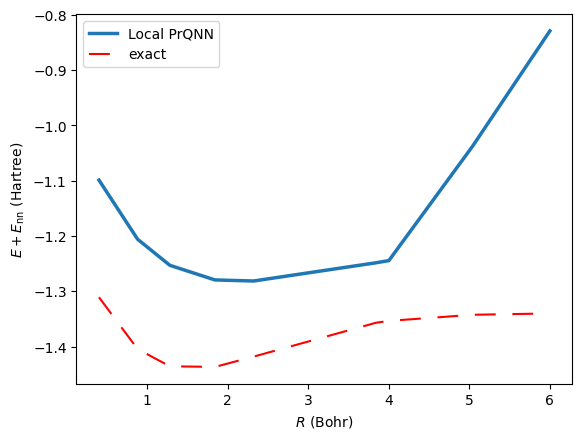

In [12]:
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + states.total_energy[:, -1], lw=2.5, label='Local PrQNN')
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + plot_set.total_energy,
    c='r', dashes=(10, 8), label='exact')
plt.xlabel(r'$R\,\,\mathrm{(Bohr)}$')
plt.ylabel(r'$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$')
plt.legend(loc=0)
plt.show()

***
## Training Global QNN

In [13]:
from qedft.models.networks import GlobalQNN
from qedft.models.wrappers import wrap_network_from_config

model = GlobalQNN(config_dict={"qnn_type": "GlobalQNN", "layer_type": "DirectQNN"})

num_points = 513
prng = jax.random.PRNGKey(0)
inputs = jax.random.uniform(
    prng,
    minval=-4 * jnp.pi,
    maxval=4 * jnp.pi,
    shape=(513,),
)

# Build network
network = model.build_network(inputs)

# Initialize parameters and run inference
init_fn, apply_fn = network
_, params = init_fn(prng, input_shape=(-1, num_points, 1))
output = apply_fn(params, inputs)


use_amplitude_encoding = True
if not use_amplitude_encoding:
    config_dict.update({'network_type': 'ksr'})
else:
    config_dict.update({'network_type': 'mlp_ksr'})

wrapped_network = wrap_network_from_config(network, grids, config_dict)

# Test direct initialization networks
init_fn, neural_xc_energy_density_fn = wrapped_network
init_params = init_fn(prng, input_shape=(1,))

# JIT the neural_xc_energy_density_fn
neural_xc_energy_density_fn = jax.jit(neural_xc_energy_density_fn)

output = neural_xc_energy_density_fn(inputs, init_params)
print("output.shape", output.shape)

spec, flatten_init_params = np_utils.flatten(init_params)

params = init_fn(prng)

neural_xc_energy_density_fn(inputs, params)

2025-04-14 16:20:49.654 | INFO     | qedft.models.quantum.convolutional_models:construct_convolutional_model:147 - Using GlobalQNNLayer layer
2025-04-14 16:20:49.679 | INFO     | qedft.models.quantum.convolutional_models:construct_convolutional_model:177 - GlobalQNNLayer Layer 0: n_qubits_layer 4
2025-04-14 16:20:49.759 | INFO     | qedft.models.quantum.quantum_models:build_qnn:682 - Building GlobalQNN QNN with DirectQNN layer_type
2025-04-14 16:20:49.760 | INFO     | qedft.models.quantum.convolutional_models:construct_convolutional_model:177 - GlobalQNNLayer Layer 1: n_qubits_layer 4
2025-04-14 16:20:49.763 | INFO     | qedft.models.quantum.quantum_models:build_qnn:682 - Building GlobalQNN QNN with DirectQNN layer_type
2025-04-14 16:20:49.763 | INFO     | qedft.models.quantum.convolutional_models:construct_convolutional_model:177 - GlobalQNNLayer Layer 2: n_qubits_layer 4
2025-04-14 16:20:49.765 | INFO     | qedft.models.quantum.quantum_models:build_qnn:682 - Building GlobalQNN QNN wi

list_kernel_dimensions , list_outputs_per_conv_layer:  [3, 3, 3, 1] [171, 57, 19, 19]


2025-04-14 16:20:56.909 | INFO     | qedft.models.wrappers:wrap_network:205 - Global model, ensuring output is scalar (wrap_self_interaction causes global models to output (num_grids,) instead of (1,))


output.shape ()


Array(1.24632253, dtype=float64)

In [14]:
config_dict.update({'use_amplitude_encoding': True})
# Create Kohn-Sham function and its batched version
kohn_sham_fn, batch_kohn_sham = create_kohn_sham_fn(
    config_dict, dataset, grids, neural_xc_energy_density_fn, spec)
# Create and initialize loss function
loss_fn = create_loss_fn(batch_kohn_sham, grids, dataset, config_dict)
# Create value and gradient function
value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))
# Create training step function
training_step = create_training_step(
    value_and_grad_fn, train_set, initial_density,
    save_every_n=1, initial_checkpoint_index=0, checkpoint_dir=project_path / 'tests' / 'global_qnn' / 'ckpts', spec=spec
)


In [15]:
# Optimize using L-BFGS-B
x, f, info = scipy.optimize.fmin_l_bfgs_b(
    training_step,
    x0=np.array(flatten_init_params),
    maxfun=2,
    factr=config_dict['factr'],
    m=config_dict['m'],
    pgtol=config_dict['pgtol'],
    maxiter=2
)

2025-04-14 16:21:00.536 | INFO     | qedft.train.od.train:_kohn_sham:115 - Jitting kohn_sham_func
2025-04-14 16:26:35.250 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 0, loss 0.6141111179260373 in 329.40152406692505 sec
2025-04-14 16:26:35.268 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/igorsokolov/PycharmProjects/qedft/tests/global_qnn/ckpts/ckpt-00000
2025-04-14 16:26:38.895 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 1, loss 0.013474685176849431 in 0.0023140907287597656 sec
2025-04-14 16:26:38.896 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/igorsokolov/PycharmProjects/qedft/tests/global_qnn/ckpts/ckpt-00001
2025-04-14 16:26:42.179 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 2, loss 0.05694744543351256 in 0.0060558319091796875 sec
2025-04-14 16:26:42.179 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/igor

In [16]:
from qedft.train.od.eval import eval_trained_model

# Plotting the states of the Kohn-Sham calculation for a given distance.
plot_distances = [40, 88, 128, 184, 232,384, 400, 504, 600] #@param
plot_set = dataset.get_molecules(plot_distances)
plot_initial_density = scf.get_initial_density(
    plot_set, method='noninteracting')
nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    plot_set.locations,
    plot_set.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)

path_to_ckpt = str(project_path) + '/tests/global_qnn/ckpts/ckpt-00002'

# Evaluating the trained model for a given distance.
states = eval_trained_model(
    ckpt_path=path_to_ckpt,
    plot_distances=plot_distances,
    plot_set=plot_set,
    plot_initial_density=plot_initial_density,
    num_electrons=dataset.num_electrons,
    num_iterations=config_dict['num_iterations'],
    grids=grids,
    neural_xc_energy_density_fn=neural_xc_energy_density_fn,
    use_amplitude_encoding=True,
    use_lda=False,
    alpha=config_dict['alpha'],
    alpha_decay=config_dict['alpha_decay'],
    num_mixing_iterations=config_dict['num_mixing_iterations'],
    density_mse_converge_tolerance=config_dict['density_mse_converge_tolerance'],
    enforce_reflection_symmetry=config_dict['enforce_reflection_symmetry'],
)

2025-04-14 16:26:46.651 | INFO     | qedft.train.od.eval:load_model_params:101 - Loading checkpoint from /Users/igorsokolov/PycharmProjects/qedft/tests/global_qnn/ckpts/ckpt-00002
2025-04-14 16:26:46.654 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 40
2025-04-14 16:26:57.243 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 88
2025-04-14 16:26:59.117 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 128
2025-04-14 16:27:03.710 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 184
2025-04-14 16:27:05.501 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 232
2025-04-14 16:27:07.035 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 384
2025-04-14 16:27:08.477 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 400
2025-04-14 16:27:10.296 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 504
2025-04-14 16:27:13.139 | INFO     | q

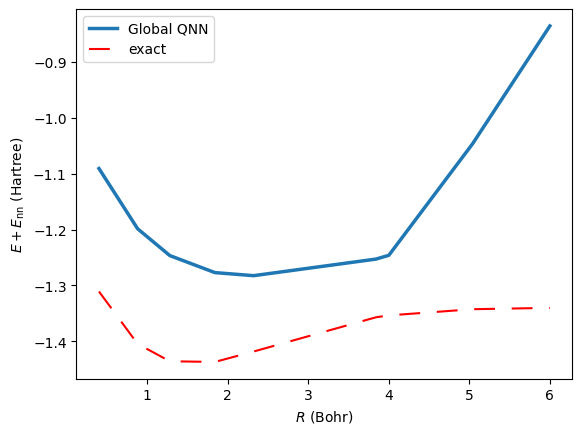

In [17]:
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + states.total_energy[:, -1], lw=2.5, label='Global QNN')
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + plot_set.total_energy,
    c='r', dashes=(10, 8), label='exact')
plt.xlabel(r'$R\,\,\mathrm{(Bohr)}$')
plt.ylabel(r'$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$')
plt.legend(loc=0)
plt.show()

# Summary

This notebook demonstrates training a quantum-enhanced DFT model:

1. Configuration setup with parameters for model architecture, training, etc.
2. Loading molecular dataset for H2 molecule with grid size 513
3. Initializing neural network for exchange-correlation energy density
4. Testing direct initialization networks with random inputs
5. Creating and training Kohn-Sham model:
   - Setting up Kohn-Sham function and batching
   - Initializing loss function
   - Creating training step with gradient computation
   - Optimizing using L-BFGS-B algorithm
6. Training with Local QNN models with different feature maps
   1. Local PrQNN
   2. Local ChQNN
7. Training with Global QNN model   
8. Plotting the states of the Kohn-Sham calculation for a given distance.